In [566]:
import torch
import pykeen
print(torch.__version__)
print(pykeen.version.VERSION)


2.9.1
1.11.1


In [567]:
import json

with open("../../items.json", "r", encoding="utf-8") as f:
    data = json.load(f)

dota_items = data.get("dota_items", {})
neutral_items = data.get("neutral_items", {})

print(len(dota_items))
print(len(neutral_items))

all_items = {}
all_items.update(dota_items)
all_items.update(neutral_items)

len(all_items)


254
62


316

In [568]:
def item_id(name): 
    return f"Item:{name}"

def ability_id(name): 
    return f"Ability:{name}"

def effect_id(name): 
    return f"Effect:{name}"

def role_id(name): 
    return f"Role:{name}"

def tier_id(t): 
    return f"Tier:{t}"

def stat_id(name, bucket): 
    return f"Stat:{name}_{bucket}"


In [569]:
def bucketize(value, bins):
    for low, high in bins:
        if low <= value < high:
            return f"{low}_{high}"
    return f"{bins[-1][0]}_plus"


In [570]:
# bucketing bins
COST_BINS = (500, 1000, 1500, 2000, 3000, 4000, 5000, 6000)
MANA_COST_BINS = (50, 100, 200)
COOLDOWN_BINS = (10, 30, 60)
BUFF_BINS = (10, 50, 100)
STAT_BINS = (10, 30, 60)

def get_bucket(value, bins):
    for i, bin_edge in enumerate(bins):
        if value < bin_edge:
            return f"{bins[i-1]}_{bin_edge}" if i > 0 else f"0_{bin_edge}"
    return f"{bins[-1]}_plus"

triples = []

# 1. Item -> Role
for name, item in all_items.items():
    for role in item.get("roles", []):
        triples.append((item_id(name), "has_role", role_id(role)))
        triples.append((role_id(role), "role_of", item_id(name)))

# 2. Ability -> Effect / AbilityType / Stats (+ bucketing)
for item in all_items.values():
    for ability in item.get("abilities", []):
        ability_name = ability["name"].replace(" ", "_").replace("'", "")

        # Ability -> Effect
        for effect in ability.get("effects", []):
            triples.append((ability_id(ability_name), "has_effect", effect_id(effect)))
            triples.append((effect_id(effect), "effect_of", ability_id(ability_name)))

        # Ability -> AbilityType
        ability_type = ability.get("ability_type")
        if ability_type:
            triples.append((ability_id(ability_name), "has_ability_type", f"AbilityType:{ability_type}"))

        # Ability -> Stats
        stats = ability.get("stats", {}).get("additional_stats", {})
        for stat_name, stat_value in stats.items():
            try:
                val = float(stat_value.strip('%'))
                bucket = get_bucket(val, STAT_BINS)
                triples.append((ability_id(ability_name), f"has_stat_{stat_name}", f"StatBucket:{bucket}"))
            except:
                pass

        # Ability -> Cooldown / ManaCost
        cd = ability.get("cooldown")
        if cd is not None:
            bucket = get_bucket(cd, COOLDOWN_BINS)
            triples.append((ability_id(ability_name), "has_cooldown", f"CooldownBucket:{bucket}"))

        mc = ability.get("mana_cost")
        if mc is not None:
            bucket = get_bucket(mc, MANA_COST_BINS)
            triples.append((ability_id(ability_name), "has_mana_cost", f"ManaBucket:{bucket}"))

# 3. Item -> Buffs
for name, item in all_items.items():
    buffs = item.get("buffs", {})
    for buff_name, val in buffs.items():
        if val is not None:
            bucket = get_bucket(val, BUFF_BINS)
            triples.append((item_id(name), f"has_buff_{buff_name}", f"BuffBucket:{bucket}"))

# 4. Item -> CostBucket
for name, item in all_items.items():
    if "cost" in item:
        bucket = get_bucket(item["cost"], COST_BINS)
        triples.append((item_id(name), "has_cost", f"CostBucket:{bucket}"))

# 5. NeutralItem -> Tier
for name, item in neutral_items.items():
    if "tier" in item:
        triples.append((item_id(name), "has_tier", tier_id(item["tier"])))


In [571]:
import pandas as pd

df_triples = pd.DataFrame(triples, columns=["head", "relation", "tail"])
print(df_triples.head())

print("Triples:", len(df_triples))
print("Entities:", len(set(df_triples["head"]) | set(df_triples["tail"])))
print("Relations:", df_triples["relation"].nunique())

                 head  relation                tail
0  Item:Abyssal Blade  has_role        Role:offense
1        Role:offense   role_of  Item:Abyssal Blade
2  Item:Abyssal Blade  has_role        Role:control
3        Role:control   role_of  Item:Abyssal Blade
4      Item:Aeon Disk  has_role        Role:utility
Triples: 3474
Entities: 552
Relations: 326


In [572]:
from pykeen.triples import TriplesFactory
import pandas as pd

df_triples = pd.DataFrame(triples, columns=["head", "relation", "tail"])

tf = TriplesFactory.from_labeled_triples(
    triples=df_triples.values
)
print(f"Entities: {len(tf.entity_to_id)}")
print(f"Relations: {len(tf.relation_to_id)}")

Entities: 552
Relations: 326


In [573]:
from pykeen.pipeline import pipeline

# train/test = 80/20
train_tf, test_tf = tf.split([0.8, 0.2], method='coverage', random_state=52)


# train model
result = pipeline(
    training=train_tf,
    testing=test_tf,
    model='TransE',  # TransE | ComplEx | DistMult
    model_kwargs=dict(embedding_dim=200),
    training_kwargs=dict(num_epochs=150, batch_size=128, use_tqdm=True),
    random_seed=52
)

model = result.model

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [1843, 640]
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
/Users/lavrent/Library/Caches/pypoetry/virtualenvs/kg-proj-yaD34q_T-py3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Training epochs on cpu: 100%|██████████| 150/150 [00:41<00:00,  3.63epoch/s, loss=0.0489, prev_loss=0.056] 
Evaluating on cpu:   0%|          | 0.00/640 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████████| 640/640 [00:00<00:00, 3.35

In [574]:
# metrics
metrics = result.metric_results.to_dict()

realistic = metrics['both']['realistic']

print("MR:", realistic['arithmetic_mean_rank'])
print("MRR:", realistic['adjusted_inverse_harmonic_mean_rank'])
print("Hits@1:", realistic['hits_at_1'])
print("Hits@3:", realistic['hits_at_3'])
print("Hits@10:", realistic['hits_at_10'])


MR: 54.810157775878906
MRR: 0.21485358153866496
Hits@1: 0.01328125
Hits@3: 0.3921875
Hits@10: 0.55078125


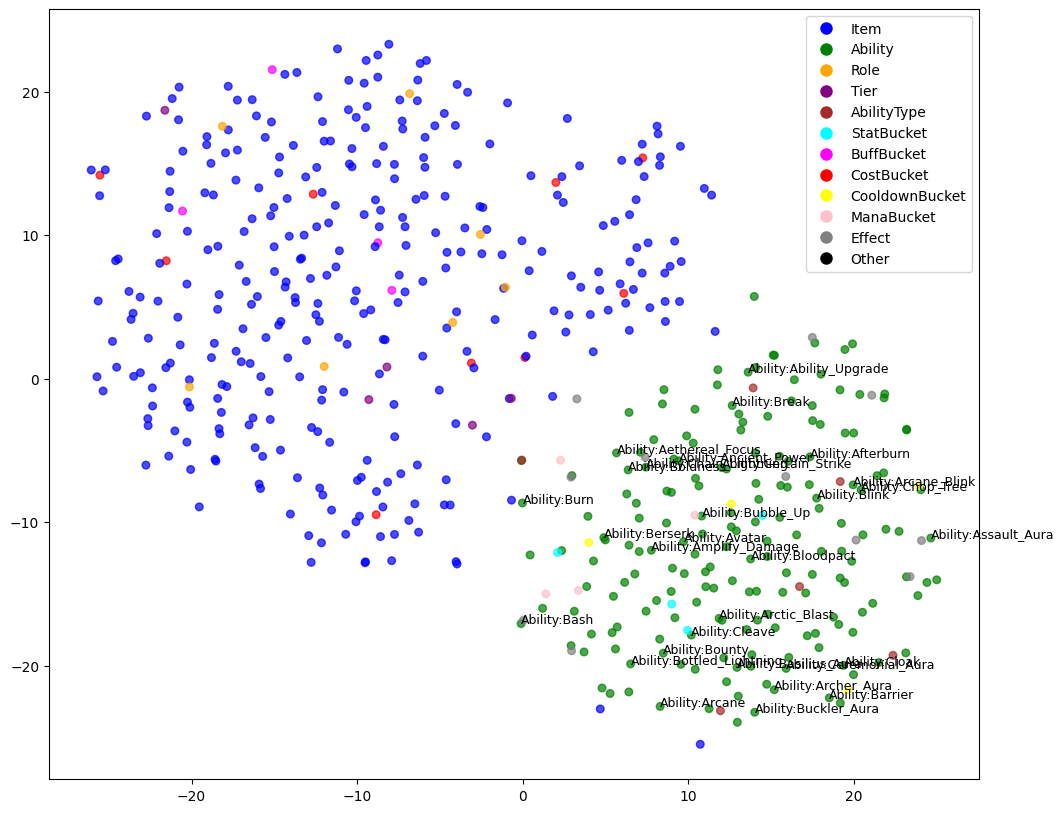

In [575]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

entity_embeddings = model.entity_representations[0](indices=None).detach().cpu().numpy()
entity_labels = list(result.training.entity_to_id.keys())


def get_entity_type(s):
    label, _ = s.split(":", 1)
    if "Bucket" in label:
        if "Stat" in label:
            return "StatBucket"
        elif "Buff" in label:
            return "BuffBucket"
        elif "Cost" in label:
            return "CostBucket"
        elif "Cooldown" in label:
            return "CooldownBucket"
        elif "Mana" in label:
            return "ManaBucket"
        else:
            return "OtherBucket"
    elif label.startswith("AbilityType"):
        return "AbilityType"
    elif label.startswith("AbilityEffect") or label == "Effect":
        return "Effect"
    elif label.startswith("Role") or label == "ItemRole" or label == "Role":
        return "Role"
    elif label == "Item":
        return "Item"
    elif label == "Ability":
        return "Ability"
    elif label == "Tier":
        return "Tier"
    else:
        print(f"warning: unknown entity {s}")
        return "Other"


entity_types = [get_entity_type(l) for l in entity_labels]

type_to_color = {
    "Item": "blue",
    "Ability": "green",
    "Role": "orange",
    "Tier": "purple",
    "AbilityType": "brown",
    "StatBucket": "cyan",
    "BuffBucket": "magenta",
    "CostBucket": "red",
    "CooldownBucket": "yellow",
    "ManaBucket": "pink",
    "Effect": "gray",
    "Other": "black",
}

colors = [type_to_color.get(t, "black") for t in entity_types]

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
entity_2d = tsne.fit_transform(entity_embeddings)

plt.figure(figsize=(12, 10))
plt.scatter(entity_2d[:, 0], entity_2d[:, 1], c=colors, alpha=0.7, s=30)


for i, label in enumerate(entity_labels[:30]):
    plt.text(entity_2d[i, 0], entity_2d[i, 1], label, fontsize=9)

# legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker="o", color="w", label=k, markerfacecolor=v, markersize=10)
    for k, v in type_to_color.items()
]
plt.legend(handles=legend_elements, loc="best")

plt.show()

# кластеризация

In [576]:
import numpy as np

item_indices = [i for i, label in enumerate(entity_labels) if label.startswith("Item:")]

X_items = entity_embeddings[item_indices]
item_labels = [entity_labels[i] for i in item_indices]


item_to_role = {}

for name, item in all_items.items():
    if "roles" in item and item["roles"]:
        item_to_role[f"Item:{name}"] = item["roles"][0]


X_items_filtered = []
item_labels_filtered = []
y_true = []

for idx in item_indices:
    label = entity_labels[idx]
    if label in item_to_role:   # есть role
        X_items_filtered.append(entity_embeddings[idx])
        item_labels_filtered.append(label)
        y_true.append(item_to_role[label])


In [577]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_true_enc = le.fit_transform(y_true)

In [578]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

X_scaled = StandardScaler().fit_transform(X_items_filtered)

X_2d = TSNE(
    n_components=2,
    perplexity=30,
    random_state=52
).fit_transform(X_scaled)


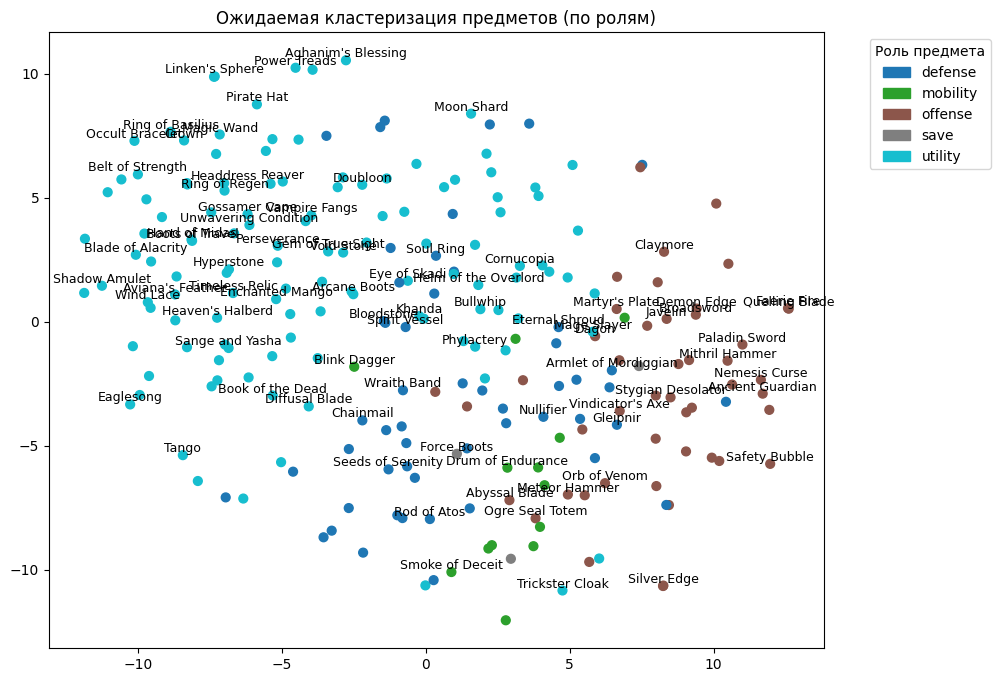

In [579]:
import matplotlib.patches as mpatches

important_items = [
    "Item:Blink Dagger",
    "Item:Black King Bar",
    "Item:Overwhelming Blink",
    "Item:Shadow Blade",
    "Item:Force Staff",
    "Item:Eul's Scepter of Divinity",
]


label_to_idx = {label: i for i, label in enumerate(item_labels_filtered)}

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

cmap = plt.cm.tab10
norm = mcolors.Normalize(
    vmin=y_true_enc.min(),
    vmax=y_true_enc.max()
)

plt.figure(figsize=(10, 8))
plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=y_true_enc,
    cmap=cmap,
    norm=norm,
    s=40
)

for name in list(label_to_idx.keys())[::3]:
    if name in label_to_idx:
        i = label_to_idx[name]
        plt.text(
            X_2d[i, 0],
            X_2d[i, 1],
            name.replace("Item:", ""),
            fontsize=9,
            ha="center",
            va="bottom",
        )

handles = []
for role_idx, role in enumerate(le.classes_):
    color = cmap(norm(role_idx))
    patch = mpatches.Patch(color=color, label=role)
    handles.append(patch)

plt.legend(
    handles=handles,
    title="Роль предмета",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

plt.title("Ожидаемая кластеризация предметов (по ролям)")
plt.show()



In [580]:
from sklearn.cluster import KMeans

n_clusters = len(set(y_true_enc))

kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=52,
    n_init=50,
    max_iter=500,
)

y_pred = kmeans.fit_predict(X_scaled)

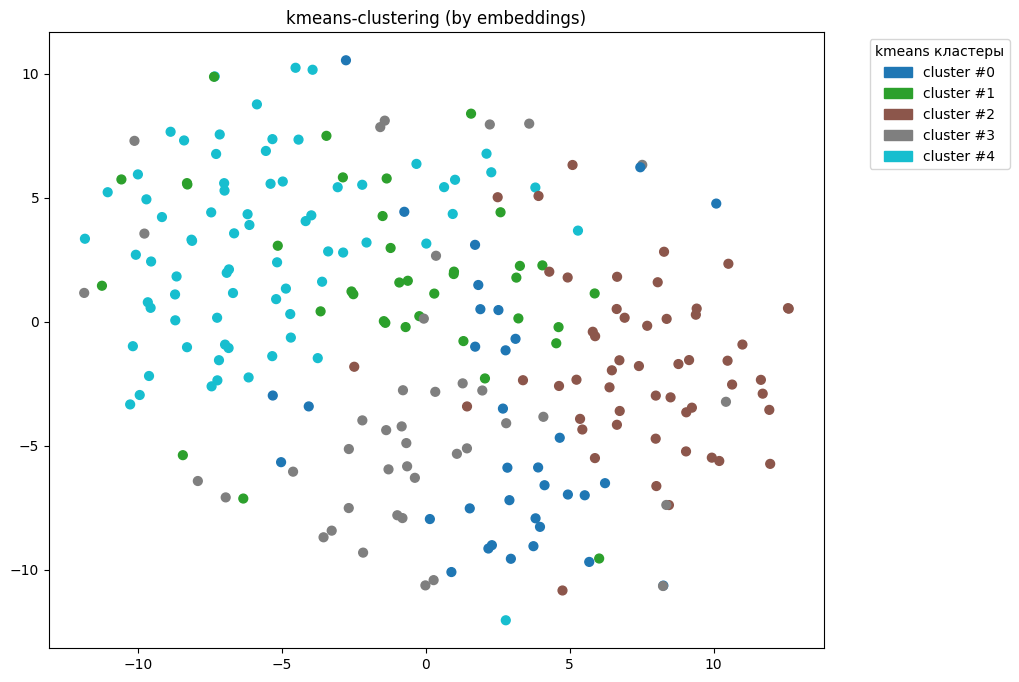

In [581]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import numpy as np

cmap = plt.cm.tab10
norm = mcolors.Normalize(vmin=y_pred.min(), vmax=y_pred.max())

plt.figure(figsize=(10, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_pred, cmap=cmap, norm=norm, s=40)

# legend
handles = []
for cluster_id in np.unique(y_pred):
    color = cmap(norm(cluster_id))
    patch = mpatches.Patch(color=color, label=f"cluster #{cluster_id}")
    handles.append(patch)

plt.legend(
    handles=handles, title="kmeans кластеры", bbox_to_anchor=(1.05, 1), loc="upper left"
)

plt.title("kmeans-clustering (by embeddings)")
plt.show()

In [582]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(y_true_enc, y_pred)
print("ARI:", ari)

ARI: 0.3526440960785073


# классификация

In [583]:
import numpy as np

entity_embeddings = model.entity_representations[0](indices=None).detach().cpu().numpy()
entity_to_id = result.training.entity_to_id

X = []
y = []

for item_name, item in all_items.items():
    item_entity = item_id(item_name)
    if item_entity not in entity_to_id:
        continue
    if not item.get("roles"):
        continue

    idx = entity_to_id[item_entity]
    emb = entity_embeddings[idx]

    role = item["roles"][0]
    X.append(emb)
    y.append(role)

X = np.array(X)
y = np.array(y)

In [584]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [587]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc_emb = accuracy_score(y_test, y_pred)

print("accuracy:", acc_emb)


accuracy: 0.75


In [589]:
from collections import Counter

most_common = Counter(y_train).most_common(1)[0][0]
y_pred_base = [most_common] * len(y_test)

acc_majority = accuracy_score(y_test, y_pred_base)
print("accuracy (majority):", acc_majority)


accuracy (majority): 0.5208333333333334


In [590]:
from sklearn.preprocessing import MultiLabelBinarizer

X_oh = []
y_oh = []

mlb = MultiLabelBinarizer()

effects_per_item = []

for item_name, item in all_items.items():
    if not item.get("roles"):
        continue

    effects = set()
    for ab in item.get("abilities", []):
        effects.update(ab.get("effects", []))

    effects_per_item.append(list(effects))
    y_oh.append(item["roles"][0])

X_oh = mlb.fit_transform(effects_per_item)


In [592]:
Xo_train, Xo_test, yo_train, yo_test = train_test_split(
    X_oh, y_oh,
    test_size=0.2,
    random_state=42,
    stratify=y_oh
)

clf_oh = LogisticRegression(max_iter=2000)
clf_oh.fit(Xo_train, yo_train)

yo_pred = clf_oh.predict(Xo_test)
acc_oh = accuracy_score(yo_test, yo_pred)
print("accuracy (one-hot):", acc_oh)


accuracy (one-hot): 0.6041666666666666
